<a href="https://colab.research.google.com/github/ShresthHirawat/Alternative-Medicine-Recommendation/blob/main/Lexical_Simplification_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from nltk import word_tokenize
from functools import lru_cache
import re
import unicodedata
import sys
from collections import Counter
import nltk
nltk.download('brown')
from nltk.corpus import brown
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## First part: The Complex Word Identification Model:

In [2]:

Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

Get the dataset to train the CWI model


In [3]:
!wget https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip

--2025-03-04 06:53:29--  https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip
Resolving www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)... 134.100.36.5
Connecting to www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)|134.100.36.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cwishareddataset.zip’

cwishareddataset.zi     [     <=>            ]   1.03M  1.12MB/s    in 0.9s    

2025-03-04 06:53:31 (1.12 MB/s) - ‘cwishareddataset.zip’ saved [1075894]



In [4]:
!unzip cwishareddataset.zip

Archive:  cwishareddataset.zip
   creating: traindevset/
   creating: traindevset/german/
  inflating: traindevset/german/German_Train.tsv  
  inflating: traindevset/german/German_Dev.tsv  
  inflating: traindevset/README.md   
   creating: traindevset/english/
  inflating: traindevset/english/WikiNews_Train.tsv  
  inflating: traindevset/english/Wikipedia_Train.tsv  
  inflating: traindevset/english/Wikipedia_Dev.tsv  
  inflating: traindevset/english/News_Dev.tsv  
  inflating: traindevset/english/News_Train.tsv  
  inflating: traindevset/english/WikiNews_Dev.tsv  
   creating: traindevset/spanish/
  inflating: traindevset/spanish/Spanish_Train.tsv  
  inflating: traindevset/spanish/Spanish_Dev.tsv  
  inflating: README.md               
   creating: testset/
   creating: testset/german/
  inflating: testset/german/German_Test.tsv  
  inflating: testset/README.md       
   creating: testset/english/
  inflating: testset/english/Wikipedia_Test.tsv  
   creating: __MACOSX/
   creating:

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target",
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

Get the glove embedding

In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-03-04 06:53:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-04 06:53:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-04 06:53:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
!unzip glove.6B.zip -d embeddings

Archive:  glove.6B.zip
  inflating: embeddings/glove.6B.50d.txt  
  inflating: embeddings/glove.6B.100d.txt  
  inflating: embeddings/glove.6B.200d.txt  
  inflating: embeddings/glove.6B.300d.txt  


Load the embedding model

In [8]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'embeddings/'


glove_models = []

glove_defs = [ Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]

for model in glove_defs:
    glove_file = MAIN_PATH + model.name
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))

print(glove_models)

<ipython-input-8-c8d29211e4f3>:15: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, tmp_file)


load model : glove.6B.300d.txt
[Model(type='glove', name='glove.6B.300d.txt', dimension=300, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.KeyedVectors object at 0x79704ced3f90>)]


Process the Dataset in order to formated it:

In [9]:
dataframe = datasets[0].train[0:30]

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def extract_ngrams_group(group):
    targets = zip(group['target'].values.tolist(), group['start'].values.tolist(),
                 group['end'].values.tolist(), group['binary'].values.tolist())
    for word, start, end, binary in targets:
        tokens = word.split()
        if len(tokens)>1:
            olap_words = [(w, b) for w, s, e, b in targets if overlaps(start, end, s, e)]


grouped = dataframe.groupby('sentence').apply(lambda group : extract_ngrams_group(group))

<ipython-input-9-039d03337b53>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = dataframe.groupby('sentence').apply(lambda group : extract_ngrams_group(group))


In [10]:
wordlist_lowercased = set(i.lower() for i in brown.words())
print (len(wordlist_lowercased))

49815


In [11]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding_model, dimension):
    all_words = [tpl[0] for sentence in sentences for tpl in sentence['seq']] + list(wordlist_lowercased)
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    vocab_size = len(counter) + 1
    print('# Vocab : {}'.format(vocab_size))
    print('# embeding model  : {}'.format(len(embedding_model.vocab)))
    word2index = {word : index for index, (word, count) in enumerate(counter.most_common(), 1)}
    index2word = {index : word for word, index in word2index.items()}
    # +1 required for pad token
    embedding_matrix = np.zeros(((vocab_size), dimension))
    missing_embed_words = []
    i_ = 0
    for word, index in word2index.items():
        if word in embedding_model.vocab:
            embedding = embedding_model[word]
        else:
             i_ +=1
             continue
        embedding_matrix[index] = embedding
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    print("i: ", i_ )
    return word2index, index2word, embedding_matrix

def forward_transformation(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    grouped = dataframe.groupby('sentence').apply(lambda row :
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0],
                         'tags': [tag for tag in zip(row['target'],
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentences = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob)
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append({'sent_id' : sent_id, 'sentence' : sentence, 'seq' : sent_repr})
    return sentences

def split_sentence_seqs(sentences):
    words, start_end, binary, prob = [], [], [] ,[]
    for sent in sentences:
        sequence = sent['seq']
        curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0],
            (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
        words.append(curr_w)
        start_end.append(curr_se)
        binary.append(curr_b)
        prob.append(curr_p)
    return words, start_end, binary, prob

In [13]:
import pandas as pd

datasets.append(Dataset(
    'train_all_test_wiki',
    pd.concat([datasets[0].train, datasets[1].train, datasets[2].train]),  # Use pd.concat instead of append
    datasets[0].test
))


In [15]:
import pandas as pd

# Select dataset
dataset_sel = datasets[3]

# Get number of rows and sentences in train set
train_num_rows = dataset_sel.train.shape[0]
train_num_sents = len(set(dataset_sel.train.sentence.tolist()))

# Get number of rows and sentences in test set
test_num_rows = dataset_sel.test.shape[0]
test_num_sents = len(set(dataset_sel.test.sentence.tolist()))

# **Fix: Use pd.concat() instead of append()**
dataset = pd.concat([dataset_sel.train, dataset_sel.test], ignore_index=True)

# Assign unique sentence IDs
dataset['sent_id'] = dataset.groupby('sentence').ngroup()

# Get dataset stats
dataset_num_rows = dataset.shape[0]
dataset_num_sents = len(set(dataset.sentence.tolist()))

# Print results
print('# Rows train : {}'.format(train_num_rows))
print('# Rows test : {}'.format(test_num_rows))
print('# Rows dataset : {}'.format(dataset_num_rows))

print('# Sents train : {}'.format(train_num_sents))
print('# Sents test : {}'.format(test_num_sents))
print('# Sents dataset : {}'.format(dataset_num_sents))


# Rows train : 27299
# Rows test : 694
# Rows dataset : 27993
# Sents train : 1988
# Sents test : 53
# Sents dataset : 2041


Finally the Dataset to train the model:

In [16]:
dataset

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,sent_id
0,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",0,8,Normally,10,10,0,1,1,0.05,1347
1,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",28,34,passed,10,10,0,1,1,0.05,1347
2,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",15,19,land,10,10,0,0,0,0.00,1347
3,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",43,49,future,10,10,1,0,1,0.05,1347
4,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",43,61,future generations,10,10,1,2,1,0.15,1347
...,...,...,...,...,...,...,...,...,...,...,...,...
27988,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,100,109,knowledge,10,10,0,2,1,0.10,929
27989,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,74,80,person,10,10,0,0,0,0.00,929
27990,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,95,99,true,10,10,0,0,0,0.00,929
27991,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,113,122,purifying,10,10,7,8,1,0.75,929


In [21]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [22]:

sentences = forward_transformation(dataset)
train_sentences = sentences[:train_num_sents]
test_sentences = sentences[train_num_sents:]

<ipython-input-11-bd1f3cce39af>:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = dataframe.groupby('sentence').apply(lambda row :


In [23]:
words, start_end, binary, prob = split_sentence_seqs(sentences)

In [24]:
sentence_lens = [len(sent) for sent in words]

The dimensions of the embedding and vectors for the model:

In [29]:
import numpy as np

def build_vocabulary(sentences, embedding_model, dimension):
    word2index = {}
    index2word = []
    embedding = []

    print(f"Building vocabulary from {len(embedding_model.key_to_index)} words...")

    # Iterate over words in the pre-trained embedding model
    for word in embedding_model.key_to_index.keys():
        word2index[word] = len(index2word)
        index2word.append(word)
        embedding.append(embedding_model[word])  # Get word vector

    print(f"Vocabulary size: {len(index2word)}")

    return word2index, index2word, np.array(embedding)


In [30]:
embedding_model = glove_models[0].model
dimension = embedding_model.vector_size  # This is fine

# ✅ Now call the fixed function
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)


Building vocabulary from 400000 words...
Vocabulary size: 400000


In [31]:
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)
print(f"Vocabulary created with {len(word2index)} words.")


Building vocabulary from 400000 words...
Vocabulary size: 400000
Vocabulary created with 400000 words.


## Padding the input sequences and get the binaries labels

In [59]:
word2index = {word.lower(): idx for idx, word in enumerate(embedding_model.key_to_index.keys())}
word2index["<UNK>"] = len(word2index)  # Assign a new index for unknown words

words_with_indices = [[word2index.get(word.lower(), word2index["<UNK>"]) for word in sent] for sent in words]
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)
binary_padded = pad_sequences(maxlen=sent_max_length, sequences=binary, padding="post", value=0)
prob_padded = pad_sequences(maxlen=sent_max_length, sequences=prob, padding="post", value=0, dtype="float")

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary_padded]

Max length sentence : 103


# Split the to train and test set


In [60]:

# (1) Training set
train_words_padded = words_padded[:train_num_sents]
train_binary_padded = binary_padded[:train_num_sents]
train_binary_padded_categorical = binary_padded_categorical[:train_num_sents]
train_prob_padded = prob_padded[:train_num_sents]
train_start_end = start_end[:train_num_sents]

# (2) Test set
test_words_padded = words_padded[train_num_sents:]
test_binary_padded = binary_padded[train_num_sents:]
test_binary_padded_categorical = binary_padded_categorical[train_num_sents:]
test_prob_padded = prob_padded[train_num_sents:]
test_start_end = start_end[train_num_sents:]

print('Training set length : {}'.format(len(train_words_padded)))
print('Test set length : {}'.format(len(test_words_padded)))

Training set length : 1988
Test set length : 53


## Create a kera's callback to validate the model on train

In [61]:
from sklearn.metrics import f1_score
import keras.callbacks
from keras import backend as K
class Metrics(keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.f1_scores = []
        self.validation_data = validation_data

    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        targ = np.array(targ)
        shape = targ.shape
        targ = targ.reshape((shape[0]*shape[1], shape[2]))
        targ = np.argmax(targ, axis = 1)
        predict = predict.reshape((shape[0]*shape[1]), shape[2])
        predict = np.argmax(predict, axis = 1)
        self.f1s=f1_score(targ, predict)
        print("\nF1 Score:")
        print(f1_score(targ, np.ones(shape[0]*shape[1])))
        self.f1_scores.append(self.f1s)
        return

## Create the keras model for the Complex Word Identification task

In [64]:
from keras.models import Model
from keras.layers import Input
from keras import backend as K
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

vocab_size = embedding.shape[0]
dimension = embedding.shape[1]

np.set_printoptions(threshold=np.inf)

in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop = Dropout(0.1)(embed)
lstm = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(drop)
out = TimeDistributed(Dense(2, activation="softmax"))(lstm)

model = Model(in_seq, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

metrics = Metrics((test_words_padded, np.array(test_binary_padded_categorical)))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 103)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 103, 300)            │     120,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 103, 300)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 103, 300)            │         541,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 103, 2)              │             602 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,541,802 (459.83 MB)

 Trainable params: 120,541,802 (459.83 MB)

 Non-trainable params: 0 (0.00 B)

And Train it:

In [65]:
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=10,
                    epochs=3, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)),
                    verbose=1, callbacks=[metrics])

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000000 elements. This may consume a large amount of memory.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

F1 Score:
0.05660377358490566
199/199 ━━━━━━━━━━━━━━━━━━━━ 151s 658ms/step - accuracy: 0.9573 - loss: 0.1107 - val_accuracy: 0.9786 - val_loss: 0.0460
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

F1 Score:
0.05660377358490566
199/199 ━━━━━━━━━━━━━━━━━━━━ 130s 628ms/step - accuracy: 0.9809 - loss: 0.0429 - val_accuracy: 0.9813 - val_loss: 0.0429
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step

F1 Score:
0.05660377358490566
199/199 ━━━━━━━━━━━━━━━━━━━━ 143s 633ms/step - accuracy: 0.9861 - loss: 0.0324 - val_accuracy: 0.9797 - val_loss: 0.0477


Now let´s plot some chart to see the model performance:

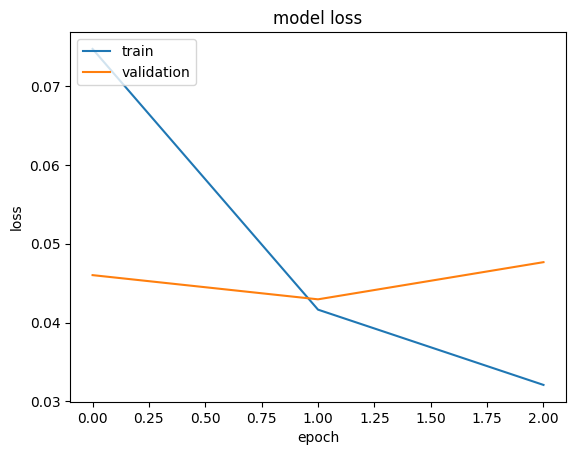

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The F1 Score

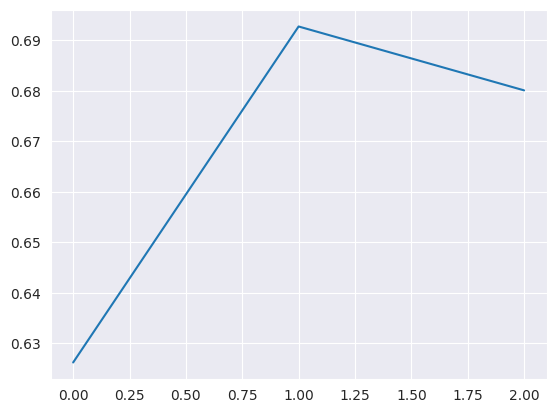

In [67]:
import seaborn as sns
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

## Optional, if you want to save the trained CWI model into your gdrive

In [68]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [69]:
model_save_name = 'model_CWI_full.h5'
path_dir = F"/content/gdrive/My Drive/{model_save_name}"

Save the model to google drive

In [70]:
from keras.models import load_model

model.save(path_dir)  # creates a HDF5 file 'model_CWI_full.h5'

Retrieve the model from google drive (if decide to save it)

In [71]:
from keras.models import load_model

model_cwi = load_model(path_dir)

## Now, let´s define some useful functions in order to use the CWI with some out of samples sentences

Function for clean the data and remove non characters symbols

In [72]:
stop_words_ = set(stopwords.words('english'))
def cleaner(word):
  #Remove links
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                '', word, flags=re.MULTILINE)
  word = re.sub('[\W]', ' ', word)
  word = re.sub('[^a-zA-Z]', ' ', word)
  return word.lower().strip()

Function for to create the padded sequence

In [73]:

def process_input(input_text):
  input_text = cleaner(input_text)
  clean_text = []
  index_list =[]
  input_token = []
  index_list_zipf = []
  for i, word in enumerate(input_text.split()):
    if word in word2index:
      clean_text.append(word)
      input_token.append(word2index[word])
    else:
      index_list.append(i)
  input_padded = pad_sequences(maxlen=sent_max_length, sequences=[input_token], padding="post", value=0)
  return input_padded, index_list, len(clean_text)


In [74]:
def complete_missing_word(pred_binary, index_list, len_list):
  list_cwi_predictions = list(pred_binary[0][:len_list])
  for i in index_list:
    list_cwi_predictions.insert(i, 0)
  return list_cwi_predictions


# Second part: The Candidates generation and selection using BERT

First, install the libraries

In [75]:
!pip install transformers
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Load the BERT  model for masked languge

In [76]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

bert_model = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model)
model = BertForMaskedLM.from_pretrained(bert_model)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', '

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-

To compute the **Zipf values**, we use the library **wordfreq**

In [77]:
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00


if we want the Zipf of the word "stop":

In [78]:
from wordfreq import zipf_frequency
zipf_frequency('stop', 'en')


5.52

and for the word "thwart":

In [79]:
from wordfreq import zipf_frequency
zipf_frequency('thwart', 'en')

3.06

As you can see the word "stop" is the most common.

## Now the function to get the candidates out of BERT (MLM):

In [80]:


def get_bert_candidates(input_text, list_cwi_predictions, numb_predictions_displayed = 10):
  list_candidates_bert = []
  for word,pred  in zip(input_text.split(), list_cwi_predictions):
    if (pred and (pos_tag([word])[0][1] in ['NNS', 'NN', 'VBP', 'RB', 'VBG','VBD' ]))  or (zipf_frequency(word, 'en')) <3.1:
      replace_word_mask = input_text.replace(word, '[MASK]')
      text = f'[CLS]{replace_word_mask} [SEP] {input_text} [SEP] '
      tokenized_text = tokenizer.tokenize(text)
      masked_index = [i for i, x in enumerate(tokenized_text) if x == '[MASK]'][0]
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [0]*len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])
      # Predict all tokens
      with torch.no_grad():
          outputs = model(tokens_tensor, token_type_ids=segments_tensors)
          predictions = outputs[0][0][masked_index]
      predicted_ids = torch.argsort(predictions, descending=True)[:numb_predictions_displayed]
      predicted_tokens = tokenizer.convert_ids_to_tokens(list(predicted_ids))
      list_candidates_bert.append((word, predicted_tokens))
  return list_candidates_bert




# Simplifying new sentences:

Given a list of new sentences with complex words:

In [81]:
list_texts = [
 'The Risk That Students Could Arrive at School With the Coronavirus As schools grapple with how to reopen, new estimates show that large parts of the country would probably see infected students if classrooms opened now.',
 'How a photograph of a young man cradling his dying friend sent me on a journey across India.',
 'Pro-democracy parties, which had hoped to ride widespread discontent to big gains, saw the yearlong delay as an attempt to thwart them.',
 'Night after night, calm gave way to chaos. See what happened between the protesters and the federal agents.',
 'Contact Tracing Is Failing in Many States. Here is Why. Inadequate testing and protracted delays in producing results have crippled tracking and hampered efforts to contain major outbreaks.',
 'After an initial decrease in the youth detention population, the rate of release has slowed, and the gap between white youth and Black youth has grown.'
 'A laboratory experiment hints at some of the ways the virus might elude antibody treatments. Combining therapies could help, experts said.',
 'Though I may not be here with you, I urge you to answer the highest calling of your heart and stand up for what you truly believe.',
 'The research does not prove that infected children are contagious, but it should influence the debate about reopening schools, some experts said.',
 'Dropping antibody counts are not a sign that our immune system is failing against the coronavirus, nor an omen that we can not develop a viable vaccine.',
 'The Senate majority leader has said he will not approve a stimulus package without a “liability shield,” but top White House officials say they do not see it as essential.',
 'Campaign efforts to refocus come as the president continues to push divisive messages that have frustrated his own party.'
]

We apply the simplifier to see how it is performing:

In [83]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
for input_text in list_texts:
  new_text = input_text
  input_padded, index_list, len_list = process_input(input_text)
  pred_cwi = model_cwi.predict(input_padded)
  pred_cwi_binary = np.argmax(pred_cwi, axis = 2)
  complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
  bert_candidates =   get_bert_candidates(input_text, complete_cwi_predictions)
  for word_to_replace, l_candidates in bert_candidates:
    tuples_word_zipf = []
    for w in l_candidates:
      if w.isalpha():
        tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
    tuples_word_zipf = sorted(tuples_word_zipf, key = lambda x: x[1], reverse=True)
    new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text)
  print("Original text: ", input_text )
  print("Simplified text:", new_text, "\n")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
Original text:  The Risk That Students Could Arrive at School With the Coronavirus As schools grapple with how to reopen, new estimates show that large parts of the country would probably see infected students if classrooms opened now.
Simplified text: The Risk That Students Could Arrive at School With the disease As schools deal with how to open new numbers show that large parts of the country would maybe see infected students if they opened now. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Original text:  How a photograph of a young man cradling his dying friend sent me on a journey across India.
Simplified text: How a shot of a young man and his dying friend sent me on a tour across India. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Original text:  Pro-democracy parties, which had hoped to ride widespread discontent to big gains, saw the yearlong delay as an attempt to thwart them.
Simplified text: Pro-democracy parties, which had hoped to ride widesp

**Pretty** **good results**